Learning Transformer

这个主要做baseline，也就是给一对时间序列的图片，然后让模型自己生成目标的恢复之后的结果。


这个既不用时间序列，也不用参考照片，只用目标序列前后的图片


然后云用mask做掩码来掩盖掉训练时的损失。

这个可以做baseline，因为他非常简单，并且比较容易实现。

In [1]:
# --------------------------------------------------------------------
# Importing required libraries
# --------------------------------------------------------------------
import random
import numpy as np
import pandas as pd
import PIL.Image as Image
from glob import glob
from mymodels import VisionTransformer, ReconNet, Classifier
from mymodels.unet import Unet
from mymodels.discriminatorv2 import Discriminator
import matplotlib.pyplot as plt
from myutils import imshow
from datetime import datetime

# importing pytorch functions
import torch
from torchvision.utils import make_grid
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as tvtransforms
from torch.nn import SmoothL1Loss, BCELoss

# importing utils required in th code
from utils import subsample
from utils import transforms
from utils.evaluate import ssim, psnr, nmse
from utils.losses import (
    SSIMLoss,
    SSIMLoss_V1,
    MultiScaleLoss,
    spectral_angle_mapper_numpy,
    peak_signal_to_noise_ratio,
    structural_similarity_index,
    CrossEntropyWithNaNMask,
)
from utils.process import transform_tensor_image, RealisticCloudMaskFunc
from osgeo import gdal
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import mean_squared_error
import math

# Device
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cuda'
# np.random.seed(42)
# random.seed(42)

print("******* STARTED AT ************", datetime.now())

/home/snt/miniconda3/envs/causal_vit_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/snt/miniconda3/envs/causal_vit_env/lib/python3.10/site-packages/timm/models/helpers.py:7: FutureWarning: Importing from timm.models.helpers is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/snt/miniconda3/envs/causal_vit_env/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


******* STARTED AT ************ 2025-01-16 23:58:31.373983


In [2]:
from sklearn.metrics import accuracy_score, f1_score
def calculate_accuracy_excluding_label(all_targets, all_preds, label_to_remove):
    flat_targets = all_targets.flatten()
    flat_preds = all_preds.flatten()

    filtered_targets = flat_targets[flat_targets != label_to_remove]
    filtered_preds = flat_preds[flat_targets != label_to_remove]
    overall_accuracy = accuracy_score(filtered_targets, filtered_preds)

    return overall_accuracy


def calculate_f1_score_excluding_label(all_targets, all_preds, label_to_remove):
    flat_targets = all_targets.flatten()
    flat_preds = all_preds.flatten()

    filtered_targets = flat_targets[flat_targets != label_to_remove]
    filtered_preds = flat_preds[flat_targets != label_to_remove]
    f1 = f1_score(filtered_targets, filtered_preds, average="weighted")
    return f1

In [3]:
class ImagenetDataset(Dataset):
    def __init__(
        self,
        isval=False,
        add_cloud_mask=True,
        add_kspace_mask=False,
        val_path="/home/snt/projects_lujun/Image-Reconstruction-by-Vision-Transformer/output_all_times/val",
        train_path="/home/snt/projects_lujun/Image-Reconstruction-by-Vision-Transformer/output_all_times/train",
    ):

        self.add_cloud_mask = add_cloud_mask
        self.add_kspace_mask = add_kspace_mask
        self.val_path = val_path
        self.train_path = train_path
        if isval:
            ## combine paths of each imagenet validation image into a single list
            self.files = []
            pattern = "*.tif"
            for dir, _, _ in os.walk(self.val_path):
                self.files.extend(glob(os.path.join(dir, pattern)))
        else:
            ## combine paths of each imagenet training image into a single list
            self.files = []  # get path of each imagenet images
            pattern = "*.tif"
            for dir, _, _ in os.walk(self.train_path):
                self.files.extend(glob(os.path.join(dir, pattern)))

        self.transform = transform_tensor_image
        self.factors = [2, 3, 4, 5, 6, 7, 8, 9, 10]

    def read_tiff(self, file_path):
        dataset = gdal.Open(file_path)
        if not dataset:
            raise FileNotFoundError(f"Unable to open the file: {file_path}")
        band_count = dataset.RasterCount
        bands_data = []
        for i in range(1, band_count + 1):
            band = dataset.GetRasterBand(i)
            band_name = band.GetDescription()
            band_data = band.ReadAsArray()
            bands_data.append(band_data)

        image = np.stack(bands_data, axis=0)
        return image

    def get_mask_func(
        self,
        samp_style,
        factor,
    ):
        center_fractions = 0.08 * 4 / factor
        if samp_style == "random":
            mask_func = subsample.RandomMaskFunc(
                center_fractions=[center_fractions],
                accelerations=[factor],
            )
        elif samp_style == "equidist":
            mask_func = subsample.EquispacedMaskFunc(
                center_fractions=[center_fractions],
                accelerations=[factor],
            )
        return mask_func

    def add_gaussian_noise(self, x):
        ch, row, col = x.shape
        mean = 0
        var = 0.05
        sigma = var**0.5
        gauss = np.random.normal(mean, sigma, (ch, row, col))
        gauss = gauss.reshape(ch, row, col)
        noisy = x + gauss
        return noisy.float()

    def __len__(
        self,
    ):
        return len(self.files)

    def __getitem__(self, idx):
        channel_count = 11
        tiff = torch.from_numpy(self.read_tiff(self.files[idx]))
        file_path = self.files[idx]
        file_name = os.path.basename(file_path)
        # tiff = self.transform(tiff, target_size=64 * 3, crop_size=60 * 3)
        channels, height, width = tiff.shape
        time_span = int((channels - 1) / channel_count)
        image = tiff[0:channel_count, :, :]

        y = image
        cloud_mask = torch.isnan(y).any(dim=0)
        cloud_mask = (~cloud_mask).int()
        y[:, cloud_mask == 0] = 0
        original_spaces_transformed = y.clone()
        masked_kspace = y.clone()

        if random.uniform(0, 1) < 0.5:
            y = torch.rot90(y, 1, [-2, -1])

        if random.uniform(0, 1) < 0.5:
            samp_style = "random"
        else:
            samp_style = "equidist"

        # factor = random.choice(self.factors)
        mask_func = self.get_mask_func(samp_style, factor=2.0)

        if self.add_kspace_mask:  # add kspace mask
            masked_kspace, _ = transforms.apply_mask(masked_kspace, mask_func)
        if self.add_cloud_mask:  # add cloud mask
            masked_kspace, added_cloud_mask = RealisticCloudMaskFunc(masked_kspace)
            added_cloud_mask = added_cloud_mask.unsqueeze(0)
        else:
            added_cloud_mask = torch.ones_like(cloud_mask.unsqueeze(0))

        cls_targets = np.squeeze(tiff[-1])

        unique_classes = torch.unique(cls_targets[~torch.isnan(cls_targets)])
        num_class = len(unique_classes)
        class_mapping = {value.item(): idx for idx, value in enumerate(unique_classes)}
        cls_targets = torch.nan_to_num(cls_targets, nan=num_class)
        cls_targets = cls_targets.apply_(lambda x: class_mapping.get(x, num_class))
        cls_targets = cls_targets.long()

        return (
            masked_kspace,  # inputs
            original_spaces_transformed,  # tragets
            cloud_mask,
            added_cloud_mask,
            cls_targets,
            file_name,
        )


train_dataset = ImagenetDataset(
    isval=False,
    add_cloud_mask=False,
    add_kspace_mask=False,
)


# ntrain = 1000
# train_dataset, _ = torch.utils.data.random_split(
#     train_dataset,
#     [ntrain, len(train_dataset) - ntrain],
#     generator=torch.Generator().manual_seed(42),
# )

val_dataset = ImagenetDataset(
    isval=True,
    add_cloud_mask=False,
    add_kspace_mask=False,
)

batch_size = 15
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

trainloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    # num_workers=2,
    pin_memory=True,
    generator=torch.Generator().manual_seed(seed),
)
valloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True,
    # num_workers=1,
    pin_memory=True,
    generator=torch.Generator().manual_seed(seed),
)

Test the mask and future application

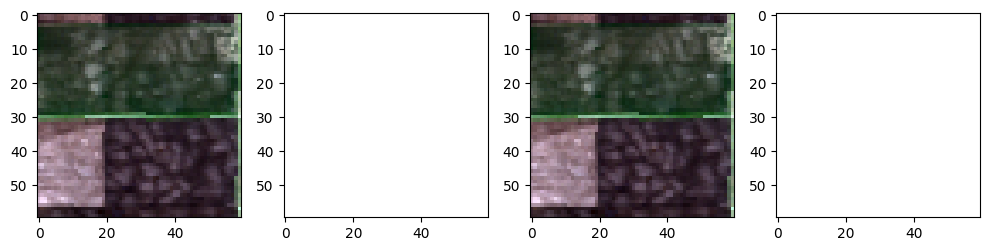

In [4]:
def read_tiff(file_path):
    dataset = gdal.Open(file_path)
    if not dataset:
        raise FileNotFoundError(f"Unable to open the file: {file_path}")
    band_count = dataset.RasterCount
    bands_data = []
    for i in range(1, band_count + 1):
        band = dataset.GetRasterBand(i)
        band_name = band.GetDescription()
        band_data = band.ReadAsArray()
        bands_data.append(band_data)

    image = np.stack(bands_data, axis=0)
    return image


def create_time_series_pseudo_color_image(iamge, cloud_mask, added_cloud_mask):
    channel_count = 11
    channel_list = [3, 2, 1]
    channels, h, w = iamge.shape
    image = iamge[0:channel_count, :, :]

    image = np.transpose(image, (1, 2, 0))
    pseudo_color_image = image[:, :, channel_list]
    # nan_mask = np.isnan(pseudo_color_image).any(axis=-1)  # 掩码，标记 NaN 的位置

    background_cloud_image = np.full((h, w, 3), 0, dtype=np.uint8)  # ALL black
    background_cloud_image[cloud_mask.squeeze(0) == 1] = [
        255,
        255,
        255,
    ]  # Eecept mask white

    background_cloud_image[added_cloud_mask.squeeze(0) == 0] = [
        255,
        0,
        0,
    ]
    return pseudo_color_image, background_cloud_image


def test_image_transformation(dataset, idx):

    masked_kspace, original_image, cloud_mask, added_cloud_masks_concat, cls_targets, _ = dataset[
        idx
    ]
    time_series_images_original, background_cloud_images_original = (
        create_time_series_pseudo_color_image(
            original_image, cloud_mask, added_cloud_masks_concat
        )
    )
    time_series_images_masked, background_cloud_images_masked = (
        create_time_series_pseudo_color_image(
            masked_kspace, cloud_mask, added_cloud_masks_concat
        )
    )
    all_images = [
        time_series_images_original,
        background_cloud_images_original,
        time_series_images_masked,
        background_cloud_images_masked,
    ]

    fig, axes = plt.subplots(1, len(all_images), figsize=(10, 10))
    dict_name = {
        0: "Original",
        1: "Mask",
        2: "Masked",
        3: "Masked+Cloud",
    }
    for i, image in enumerate(all_images):
        axes[i].imshow(image)
        axes[i].axis("on")
    plt.tight_layout()
    plt.show()


idx = 20
test_image_transformation(train_dataset, idx)

In [5]:
from sklearn.metrics import accuracy_score, f1_score
import torch.nn as nn

# --------------------------------------------------------------------
# Initialising Models
# --------------------------------------------------------------------
class VisionTransformerWithSARCLS(nn.Module):
    def __init__(self, vision_transformer, classifier):
        super(VisionTransformerWithSARCLS, self).__init__()
        self.feature_extractor = vision_transformer.to(device)
        self.classifier = classifier.to(device)

    def forward(self, x):
        features = self.feature_extractor(x)
        output = self.classifier(features)
        return output


# --------------------------------------------------------------------
# Initialising Models
# --------------------------------------------------------------------
masked_kspace, _, _, _, _,_ = train_dataset[0]
C, H, W = masked_kspace.shape

channel_count = 11
avrg_img_size = 180  # Don't change this
patch_size = 5  # 10
depth = 6
num_heads = 8
embed_dim = 11  # 64
time_span = C // channel_count
in_chans = C
epoch_max = 100
lr = 1e-4
is_SGD = False
batch_size = 60
seed = 42
num_classes = 2

current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = f"/home/snt/projects_lujun/vitCausalSeries/data/training/logs/my_experiment_{current_time}_reconstruction_single_vit"
path = log_dir


torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

trainloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    # num_workers=2,
    pin_memory=True,
    generator=torch.Generator().manual_seed(seed),
)
valloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True,
    # num_workers=1,
    pin_memory=True,
    generator=torch.Generator().manual_seed(seed),
)


net = VisionTransformer(
    avrg_img_size=avrg_img_size,
    patch_size=patch_size,
    in_chans=in_chans,
    embed_dim=embed_dim,
    depth=depth,
    num_heads=num_heads,
    is_LSA=False,  # ---------------Parameter for adding LSA component
    is_SPT=False,  # ---------------Parameter for adding SPT component
    rotary_position_emb=False,  # ---------------Parameter for adding ROPE component
    use_pos_embed=True,
)


transformer_net = ReconNet(net).to(device)
classifier = Classifier(in_channels=channel_count, cls_class=2).to(device)
model = VisionTransformerWithSARCLS(transformer_net, classifier)

checkpoint_base_folder = "/home/snt/projects_lujun/vitCausalSeries/data/training/logs"
training_model_folder = "my_experiment_20250109-121958_reconstruction_single_vit"
checkpoint_path = f"{checkpoint_base_folder}/{training_model_folder}/checkpoint_60.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)
model.feature_extractor.load_state_dict(checkpoint["model_state_dict"])



## Set biases to zero
for name, param in model.named_parameters():
    if name.endswith(".bias"):
        torch.nn.init.constant_(param, 0)
        param.requires_grad = False

# Freeze the feature extractor
for param in model.feature_extractor.parameters():
    param.requires_grad = False

print("#Params:", sum(p.numel() for p in model.parameters() if p.requires_grad))
print(model)


# --------------------------------------------------------------------
# Function to Save model
# --------------------------------------------------------------------
def save_model(path, model, train_hist, optimizer, scheduler=None, epoch=None):
    if epoch is None:
        epoch = 0
    else:
        epoch = epoch + 1
    if scheduler:
        checkpoint = {
            "model": VisionTransformerWithSARCLS(model.feature_extractor, model.classifier),
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler": scheduler.state_dict(),
        }
    else:
        checkpoint = {
            "model": VisionTransformerWithSARCLS(model.feature_extractor, model.classifier),
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }

    torch.save(train_hist, path + f"/train_hist_{epoch}.pt")
    torch.save(checkpoint, path + f"/checkpoint_{epoch}.pth")

criterion_cls = CrossEntropyWithNaNMask(num_classes=num_classes).to(device)


"""Choose optimizer"""

# criterion = SSIMLoss_V1(window_size=11, channel=1).to(device)
# criterion = ms_ssim().to(device)
# criterion = piq.ssim().to(device)
criterion = MultiScaleLoss(scales=[1, 0.5, 0.25], weight_mse=1.0, weight_sam=1.0).to(
    device
)


if is_SGD:
    optimizerG = optim.SGD(
        model.classifier.parameters(),
        lr=lr,
        momentum=0.9,
    )
    cycle_momentum = True
    base_momentum = (0.85,)
    max_momentum = (0.95,)

else:
    optimizerG = optim.Adam(model.classifier.parameters(), lr=0.0)
    cycle_momentum = False
    base_momentum = 0.0
    max_momentum = 0.0


train_hist = []

scheduler = optim.lr_scheduler.OneCycleLR(
    optimizerG,
    max_lr=lr,
    total_steps=epoch_max,
    pct_start=0.1,
    anneal_strategy="cos",
    cycle_momentum=cycle_momentum,
    base_momentum=base_momentum,
    max_momentum=max_momentum,
    div_factor=0.1 * epoch_max,
    final_div_factor=9,
)


def check_nan_in_tensors(*tensors):
    for idx, tensor in enumerate(tensors):
        if torch.isnan(tensor).any():
            print(f"Tensor {idx} contains NaN values.")
            return True
    print("No NaN values found in the provided tensors.")
    return False

#Params: 1569408
VisionTransformerWithSARCLS(
  (feature_extractor): ReconNet(
    (net): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(11, 88, kernel_size=(5, 5), stride=(5, 5))
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (blocks): ModuleList(
        (0-5): 6 x Block(
          (norm1): LayerNorm((88,), eps=1e-05, elementwise_affine=True)
          (attn): MHSA(
            (attend): Softmax(dim=-1)
            (to_qkv): Linear(in_features=88, out_features=1056, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=352, out_features=88, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
          (drop_path): Identity()
          (norm2): LayerNorm((88,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=88, out_features=352, bias=True)
            (act): GELU(approximate='none')
            (fc2): Linear(in_features=352, out_fe

/tmp/ipykernel_1038266/3590284791.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Start to train the model

In [24]:
# --------------------------------------------------------------------
# Start to train the model
# --------------------------------------------------------------------

# Initialize TensorBoard writer
writer = SummaryWriter(log_dir=log_dir)

for epoch in range(0, epoch_max):  # loop over the dataset multiple times
    model.train()
    train_loss = 0.0

    for i, data in enumerate(trainloader):
        inputs, targets, cloud_mask, added_cloud_mask, cls_targets, _ = data
        channel_each = inputs.shape[1] // time_span
        last_time_start = channel_each * (time_span - 1)
        last_time_end = channel_each * time_span
        optimizerG.zero_grad()
        images_outputs = model.feature_extractor(inputs.to(device))
        cls_outputs = model.classifier(images_outputs.to(device))
        valid_pixels_total = cloud_mask.sum()
        if valid_pixels_total > 0:
            loss = criterion_cls(
                cls_outputs.to(device),
                cls_targets.to(device),
            )
        else:
            loss = torch.tensor(0.0, device=device, requires_grad=True)
            
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            model.parameters(), max_norm=1, norm_type=1, error_if_nonfinite=True
        )
        optimizerG.step()
        train_loss += loss.item()

    writer.add_scalar("Loss/Train", train_loss, epoch)

    model.eval()
    val_loss = 0.0
    all_preds = []
    all_targets = []


    with torch.no_grad():
        for inputs, targets, cloud_mask, added_cloud_mask, cls_targets, _ in valloader:
            images_outputs = model.feature_extractor(inputs.to(device))
            cls_outputs = model.classifier(images_outputs.to(device))
            # Apply cloud mask to outputs and targets

            # Compute validation loss
            valid_pixels_total = cloud_mask.sum()
            if valid_pixels_total > 0:
                loss = criterion_cls(
                    cls_outputs.to(device),
                    cls_targets.to(device),
                )
            else:
                loss = torch.tensor(0.0, device=device, requires_grad=False)

            val_loss += loss.item()

            # Collect predictions and targets for additional metrics
            preds = (
                cls_outputs.argmax(dim=1).cpu().numpy()
            )  # Assuming class indices are returned as outputs
            targets_cls = cls_targets.cpu().numpy()

            all_preds.extend(preds)
            all_targets.extend(targets_cls)

        # Compute additional metrics
        OAs = []
        F1s = []
        for i in range(len(all_preds)):
            overall_accuracy = calculate_accuracy_excluding_label(
                all_targets[i], all_preds[i], num_classes
            )
            f1 = calculate_f1_score_excluding_label(
                all_targets[i], all_preds[i], num_classes
            )
            OAs.append(overall_accuracy)
            F1s.append(f1)
        average_accuracy = np.mean(OAs)
        average_f1 = np.mean(F1s)

    # Log validation loss and metrics to TensorBoard
    writer.add_scalar("Loss/Validation", val_loss, epoch)
    writer.add_scalar("Accuracy/Validation", average_accuracy, epoch)
    writer.add_scalar("F1_Score/Validation", average_f1, epoch)

    if not is_SGD:
        scheduler.step()
    train_hist.append(train_loss / len(trainloader))
    # save_model(path, model, train_hist, optimizerG, scheduler=scheduler)
    print("Epoch {}, Train loss.: {:0.4e}".format(epoch + 1, train_hist[-1]))
    print(f"Epoch {epoch + 1} - Validation Loss: {val_loss:.4e}")
    print(f"Epoch {epoch + 1} - Overall Accuracy: {average_accuracy:.4f}")
    print(f"Epoch {epoch + 1} - Classification F1 Score: {average_f1:.4f}")

    if (epoch + 1) % 5 == 0:
        save_model(
            path, model, train_hist, optimizerG, scheduler=scheduler, epoch=epoch
        )
        print(f"Model saved at epoch {epoch + 1}")

Epoch 1, Train loss.: 8.5560e-01
Epoch 1 - Validation Loss: 3.3831e+01
Epoch 1 - Overall Accuracy: 0.7991
Epoch 1 - Classification F1 Score: 0.7443
Epoch 2, Train loss.: 7.8523e-01
Epoch 2 - Validation Loss: 3.3650e+01
Epoch 2 - Overall Accuracy: 0.8001
Epoch 2 - Classification F1 Score: 0.7447
Epoch 3, Train loss.: 7.8312e-01
Epoch 3 - Validation Loss: 3.3581e+01
Epoch 3 - Overall Accuracy: 0.7984
Epoch 3 - Classification F1 Score: 0.7494
Epoch 4, Train loss.: 7.8238e-01
Epoch 4 - Validation Loss: 3.3541e+01
Epoch 4 - Overall Accuracy: 0.8008
Epoch 4 - Classification F1 Score: 0.7464
Epoch 5, Train loss.: 7.8155e-01
Epoch 5 - Validation Loss: 3.3506e+01
Epoch 5 - Overall Accuracy: 0.8014
Epoch 5 - Classification F1 Score: 0.7470
Model saved at epoch 5
Epoch 6, Train loss.: 7.8115e-01
Epoch 6 - Validation Loss: 3.3574e+01
Epoch 6 - Overall Accuracy: 0.7996
Epoch 6 - Classification F1 Score: 0.7470
Epoch 7, Train loss.: 7.8126e-01
Epoch 7 - Validation Loss: 3.3537e+01
Epoch 7 - Overall 

KeyboardInterrupt: 

## Validation Procedure

In [35]:
class ImagenetDataset(Dataset):
    def __init__(
        self,
        isval=False,
        add_cloud_mask=True,
        add_kspace_mask=False,
        val_path="/home/snt/projects_lujun/Image-Reconstruction-by-Vision-Transformer/output_all_times/val",
        train_path="/home/snt/projects_lujun/Image-Reconstruction-by-Vision-Transformer/output_all_times/train",
    ):

        self.add_cloud_mask = add_cloud_mask
        self.add_kspace_mask = add_kspace_mask
        self.val_path = val_path
        self.train_path = train_path
        if isval:
            ## combine paths of each imagenet validation image into a single list
            self.files = []
            pattern = "*.tif"
            for dir, _, _ in os.walk(self.val_path):
                self.files.extend(glob(os.path.join(dir, pattern)))
        else:
            ## combine paths of each imagenet training image into a single list
            self.files = []  # get path of each imagenet images
            pattern = "*.tif"
            for dir, _, _ in os.walk(self.train_path):
                self.files.extend(glob(os.path.join(dir, pattern)))

        self.transform = transform_tensor_image
        self.factors = [2, 3, 4, 5, 6, 7, 8, 9, 10]

    def read_tiff(self, file_path):
        dataset = gdal.Open(file_path)
        if not dataset:
            raise FileNotFoundError(f"Unable to open the file: {file_path}")
        band_count = dataset.RasterCount
        bands_data = []
        for i in range(1, band_count + 1):
            band = dataset.GetRasterBand(i)
            band_name = band.GetDescription()
            band_data = band.ReadAsArray()
            bands_data.append(band_data)

        image = np.stack(bands_data, axis=0)
        return image

    def get_mask_func(
        self,
        samp_style,
        factor,
    ):
        center_fractions = 0.08 * 4 / factor
        if samp_style == "random":
            mask_func = subsample.RandomMaskFunc(
                center_fractions=[center_fractions],
                accelerations=[factor],
            )
        elif samp_style == "equidist":
            mask_func = subsample.EquispacedMaskFunc(
                center_fractions=[center_fractions],
                accelerations=[factor],
            )
        return mask_func

    def add_gaussian_noise(self, x):
        ch, row, col = x.shape
        mean = 0
        var = 0.05
        sigma = var**0.5
        gauss = np.random.normal(mean, sigma, (ch, row, col))
        gauss = gauss.reshape(ch, row, col)
        noisy = x + gauss
        return noisy.float()

    def __len__(
        self,
    ):
        return len(self.files)

    def __getitem__(self, idx):
        channel_count = 11
        tiff = torch.from_numpy(self.read_tiff(self.files[idx]))
        file_path = self.files[idx]
        file_name = os.path.basename(file_path)
        # tiff = self.transform(tiff, target_size=64 * 3, crop_size=60 * 3)
        channels, height, width = tiff.shape
        time_span = int((channels - 1) / channel_count)
        image = tiff[0:channel_count, :, :]

        y = image
        cloud_mask = torch.isnan(y).any(dim=0)
        cloud_mask = (~cloud_mask).int()
        y[:, cloud_mask == 0] = 0
        original_spaces_transformed = y.clone()
        masked_kspace = y.clone()

        if random.uniform(0, 1) < 0.5:
            y = torch.rot90(y, 1, [-2, -1])

        if random.uniform(0, 1) < 0.5:
            samp_style = "random"
        else:
            samp_style = "equidist"

        # factor = random.choice(self.factors)
        mask_func = self.get_mask_func(samp_style, factor=2.0)

        if self.add_kspace_mask:  # add kspace mask
            masked_kspace, _ = transforms.apply_mask(masked_kspace, mask_func)
        if self.add_cloud_mask:  # add cloud mask
            masked_kspace, added_cloud_mask = RealisticCloudMaskFunc(
                    masked_kspace, clouds_attributes={"cloud_count": 0}
                )
            added_cloud_mask = added_cloud_mask.unsqueeze(0)
        else:
            added_cloud_mask = torch.ones_like(cloud_mask.unsqueeze(0))

        cls_targets = np.squeeze(tiff[-1])

        unique_classes = torch.unique(cls_targets[~torch.isnan(cls_targets)])
        num_class = len(unique_classes)
        class_mapping = {value.item(): idx for idx, value in enumerate(unique_classes)}
        cls_targets = torch.nan_to_num(cls_targets, nan=num_class)
        cls_targets = cls_targets.apply_(lambda x: class_mapping.get(x, num_class))
        cls_targets = cls_targets.long()

        return (
            masked_kspace,  # inputs
            original_spaces_transformed,  # tragets
            cloud_mask,
            added_cloud_mask,
            cls_targets,
            file_name,
        )

In [36]:
import torch
from tqdm import tqdm
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = "cuda" if torch.cuda.is_available() else "cpu"

if_write = False
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = f"/home/snt/projects_lujun/vitCausalSeries/data/training/logs/my_experiment_{current_time}"
path = log_dir
val_path = "/home/snt/projects_lujun/vitCausalSeries/data/intermediate_SAR_2021"
checkpoint_base_folder = "/home/snt/projects_lujun/vitCausalSeries/data/training/logs"
training_model_folder = "my_experiment_20250116-224713_reconstruction_single_vit"

checkpoint_path = f"{checkpoint_base_folder}/{training_model_folder}/checkpoint_40.pth"

outputs_folder = f"{checkpoint_base_folder}/{training_model_folder}/masked_outputs"
targets_folder = f"{checkpoint_base_folder}/{training_model_folder}/masked_targets"
inputs_folder = f"{checkpoint_base_folder}/{training_model_folder}/masked_inputs"
cloud_mask_folder = f"{checkpoint_base_folder}/{training_model_folder}/cloud_mask"


val_dataset = ImagenetDataset(
    isval=True,
    add_cloud_mask=True,
    add_kspace_mask=False,
    val_path=val_path,
)
batch_size = 20
valloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    # num_workers=1,
    pin_memory=True,
    generator=torch.Generator().manual_seed(seed),
)


checkpoint = torch.load(checkpoint_path, map_location=device)

model.load_state_dict(checkpoint["model_state_dict"])

# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# epoch = checkpoint['epoch']

print("Checkpoint loaded successfully!")


def write_tiff(output_path, image):
    if image.ndim == 2:
        image = image[np.newaxis, ...]

    bands, height, width = image.shape

    driver = gdal.GetDriverByName("GTiff")
    dataset = driver.Create(
        output_path,
        width,
        height,
        bands,
        gdal.GDT_Float32,
    )

    if dataset is None:
        raise RuntimeError(f"Unable to create TIFF file: {output_path}")

    # Write each band to the dataset
    for i in range(bands):
        band = dataset.GetRasterBand(i + 1)
        band.WriteArray(image[i, :, :])
        band.FlushCache()  # Ensure data is written to disk

    dataset = None

Checkpoint loaded successfully!


/tmp/ipykernel_1038266/3641123685.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


In [37]:
model.eval()
val_loss = 0.0
all_preds = []
all_targets = []


with torch.no_grad():
    for inputs, targets, cloud_mask, added_cloud_mask, cls_targets, _ in valloader:
        images_outputs = model.feature_extractor(inputs.to(device))
        cls_outputs = model.classifier(images_outputs.to(device))
        # Apply cloud mask to outputs and targets

        # Compute validation loss
        valid_pixels_total = cloud_mask.sum()
        if valid_pixels_total > 0:
            loss = criterion_cls(
                cls_outputs.to(device),
                cls_targets.to(device),
            )
        else:
            loss = torch.tensor(0.0, device=device, requires_grad=False)

        val_loss += loss.item()

        # Collect predictions and targets for additional metrics
        preds = (
            cls_outputs.argmax(dim=1).cpu().numpy()
        )  # Assuming class indices are returned as outputs
        targets_cls = cls_targets.cpu().numpy()

        all_preds.extend(preds)
        all_targets.extend(targets_cls)

    # Compute additional metrics
    OAs = []
    F1s = []
    for i in range(len(all_preds)):
        overall_accuracy = calculate_accuracy_excluding_label(
            all_targets[i], all_preds[i], num_classes
        )
        f1 = calculate_f1_score_excluding_label(
            all_targets[i], all_preds[i], num_classes
        )
        OAs.append(overall_accuracy)
        F1s.append(f1)
    average_accuracy = np.nanmean(OAs)
    average_f1 = np.nanmean(F1s)


print(f"Validation Loss: {val_loss:.4e}")
print(f"Overall Accuracy: {average_accuracy:.4f}")
print(f"Classification F1 Score: {average_f1:.4f}")


Validation Loss: 4.8701e+01
Overall Accuracy: 0.5940
Classification F1 Score: 0.5136
